In [152]:
# -*- coding: utf-8 -*-
import h5py
import numpy as np
import os

from sklearn.model_selection import train_test_split
from lesion_extraction_2d.lesion_extractor_2d import parse_centroid, get_lesion_info, get_train_data, extract_lesion_2d

import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from PIL import Image
import scipy
import matplotlib.pyplot as plt
%matplotlib inline

In [153]:
h5_file_location = os.path.join('./','prostatex-train-ALL.hdf5')
h5_file = h5py.File(h5_file_location, 'r')

In [154]:
h5_file['ProstateX-0000'].keys()

<KeysViewHDF5 ['Ktrans', 'ep2d_diff_tra_DYNDIST', 'ep2d_diff_tra_DYNDISTCALC_BVAL', 'ep2d_diff_tra_DYNDIST_ADC', 't2_tse_cor', 't2_tse_sag', 't2_tse_tra', 'tfl_3d PD ref_tra_1.5x1.5_t3']>

In [155]:
def extract_2d(img, centroid, size=None, resolution=None):
    if resolution: 
        img = scipy.ndimage.zoom(img, resolution)
        centroid.zoom(resolution)
    if len(img.shape) == 3:
        if centroid.z < 0 or centroid.z >= len(img):
            return None
        img_slice = img[centroid.z]
    else:
        img_slice = img
    if size:
        x_start = int(centroid.x - size / 2)
        x_end = int(centroid.x + size / 2)
        y_start = int(centroid.y - size / 2)
        y_end = int(centroid.y + size / 2)
        img_slice = img_slice[y_start:y_end, x_start:x_end]
    return img_slice

def get_2d_images(h5_file, query_words, size=None, resolution=None):
    lesion_info = get_lesion_info(h5_file, query_words)
    X, y, lesion_attributes, previous_patient = [], [], [], ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning in {}: Found duplicate match for {}. Skipping...'
                  .format(get_2d_images.__name__, current_patient))
            continue
        for lesion in infos:
            centroid = parse_centroid(lesion['ijk'])
            # lesion_img = extract_2d(image, centroid, size, resolution)
            lesion_img = image[centroid.z] if centroid.z > 0 and centroid.z < len(image) else None
            if lesion_img is None:
                print('Warning in {}: ijk out of bounds for {}. No lesion extracted'
                      .format(get_2d_images.__name__, lesion))
                continue
            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)
        previous_patient = current_patient
    return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)

In [156]:
query = ['t2_tse_tra', 'BVAL', 'ADC', 'Ktrans']
resolution = {'t2_tse_tra':0.5, 'BVAL': 2, 'ADC': 2, 'Ktrans': 1.5}
data = {q: get_2d_images(h5_file, [q]) for q in query}
# data = {q: get_2d_images(h5_file, [q], 64, resolution[q]) for q in query}


Warning in get_2d_images: Found duplicate match for ProstateX-0032. Skipping...
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0148/t2_tse_tra', 'patient_id': '0148', 'ijk': b'201 162 23', 'VoxelSpacing': b'0.5,0.5,4.', 'Zone': b'AS', 'ClinSig': b'TRUE', 'fid': '1', 'Age': '063Y'}. No lesion extracted
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0148/t2_tse_tra', 'patient_id': '0148', 'ijk': b'149 206 24', 'VoxelSpacing': b'0.5,0.5,4.', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '2', 'Age': '063Y'}. No lesion extracted
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_2d_images: ijk out of bounds for {'name': '/ProstateX-0189/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0189', 'ijk': b'40 65 0', 'VoxelSpacing': b'2,2,

In [157]:
findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
for q in query:
    images, labels, attrs = data[q]
    for i in range(len(images)):
        f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
        image = images[i]
        image = image.astype(np.float64)
        centroid = parse_centroid(attrs[i]['ijk'])        
        image = extract_2d(image, centroid, 64, resolution[q])
        # image = extract_2d(image, centroid, resolution[q])
        image = image / image.max()
        if image is None: print(f)
        findings[f][q] = image
        if 'label' not in findings[f]:
            findings[f]['label'] = labels[i]
        else:
            assert(findings[f]['label'] == labels[i])
findings = {k:v for k, v in findings.items() if len(v.keys()) == len(query) + 1}
print("Total findings for train/val: ", len(findings))

Total findings for train/val:  318


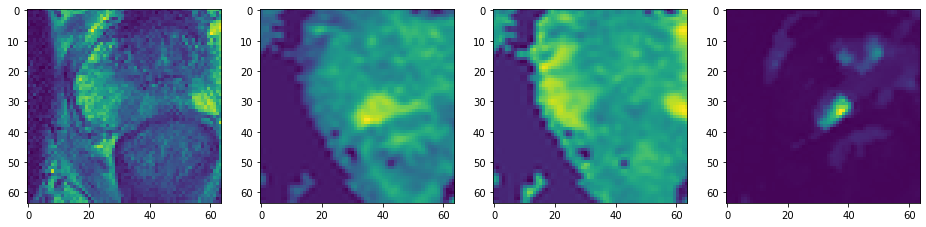

In [158]:
fig, axes = plt.subplots(1, 4, figsize=(16, 9))
for i, img in enumerate([findings['0000-1'][q] for q in query]):
    axes[i].imshow(img)

In [159]:
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

In [160]:
splitted = train_test_split(
    images, labels, test_size=0.25, random_state=0, stratify=labels)
# X_train, X_valid, y_train, y_valid = (torch.Tensor(array) for array in splitted)
X_train, X_valid, y_train, y_valid = splitted
len_oversampled = len(y_train) - int(y_train.sum()) * 2
print("Train, len_1, len_oversampled: ", 
    len(y_train), int(y_train.sum()), len_oversampled)

oversampled = np.random.choice(np.where(y_train == 1)[0], len_oversampled)
X_train = np.concatenate((X_train, X_train[oversampled]), 0)
y_train = np.concatenate((y_train, y_train[oversampled]), 0)

Train, len_1, len_oversampled:  238 55 128


In [161]:
images.shape

(318, 4, 64, 64)

In [29]:
dirname = 'tbak_images'
_ = [os.makedirs(dirname+split+label) for split in ['/train', '/valid', '/valid_bal'] for label in ['/0', '/1']]
for i in range(X_train.shape[0]):
    image = X_train[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
    im.save(dirname + '/train/{}/{}.png'.format(1 if y_train[i] else 0, i))
for i in range(X_valid.shape[0]):
    image = X_valid[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
    im.save(dirname + '/valid/{}/{}.png'.format(1 if y_valid[i] else 0, i))
    if i <= X_valid.shape[0]//2:
        im.save(dirname + '/valid_bal/{}/{}.png'.format(1 if y_valid[i] else 0, i))

In [163]:
dirname = 'tbak_npy'
_ = [os.makedirs(dirname+split+label) for split in ['/train', '/valid', '/valid_bal'] for label in ['/0', '/1']]
for i in range(X_train.shape[0]):
    image = X_train[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/train/{}/{}.npy'.format(1 if y_train[i] else 0, i)
    np.save(open(path, "wb"), im)
for i in range(X_valid.shape[0]):
    image = X_valid[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = np.moveaxis(rescaled, 0, -1)
    path = dirname + '/valid/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
    np.save(open(path, "wb"), im)
    if i <= X_valid.shape[0]//2:
        path = dirname + '/valid_bal/{}/{}.npy'.format(1 if y_valid[i] else 0, i)
        np.save(open(path, "wb"), im)

## 2D 32x32

In [38]:
# query = ['BVAL', 'ADC', 't2_tse_tra', 't2_tse_cor', 't2_tse_sag', 'Ktrans']
query = ['BVAL', 'ADC', 'Ktrans']
data = {q: get_train_data(h5_file, [q], size_px=32) for q in query}



Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDISTCALC_BVAL', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST_ADC', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...
Warning in get_train_data: ijk out of bounds for {'name': '/ProstateX-0025/Ktrans', 'patient_id': '0025', 'ijk': b'67 88 -7', 'VoxelSpacing': b'1.5,1.5,3.', 'Zon

In [39]:
findings = {attr['patient_id'] + '-' + attr['fid']:{} for q in query for attr in data[q][2]}
for q in query:
    images, labels, attrs = data[q]
    for i in range(len(images)):
        f = attrs[i]['patient_id'] + '-' + attrs[i]['fid']
        image = images[i].astype(np.float64)
        findings[f][q] = image / image.max()
        if 'label' not in findings[f]:
            findings[f]['label'] = labels[i]
        else:
            assert(findings[f]['label'] == labels[i])
findings = {k:v for k, v in findings.items() if len(v.keys()) == len(query) + 1}
print("Total findings for train/val: ", len(findings))

Total findings for train/val:  321


In [40]:
images = np.stack([np.stack([findings[f][q] for q in query]) for f in findings])
labels = np.stack([findings[f]['label'] for f in findings])

## DWI

In [47]:
def filename_to_patient_id(name):
    return name[11:15]

def get_lesion_info_from_query(query):
    include_attrs = ['ijk', 'VoxelSpacing', 'Zone', 'ClinSig']
    lesions_info = []
    for h5_group in query:
        if 'pixel_array' not in h5_group or 'lesions' not in h5_group:
            print('Warning in {}: No pixel array or lesions found for {}. Skipping...'
                  .format(get_lesion_info, h5_group))
            continue
        pixel_array = h5_group['pixel_array'][:]  # The actual DICOM pixel data
        patient_age = h5_group['pixel_array'].attrs.get('Age')
        lesion_info = []
        for finding_id in h5_group['lesions'].keys():
            lesion_dict = {
                'name': h5_group.name,
                'patient_id': filename_to_patient_id(h5_group.name)
            }
            for attr in include_attrs:
                # Per lesion finding, gather the attributes necessary for actual lesion extraction from DICOM image
                lesion_dict[attr] = h5_group['lesions'][finding_id].attrs.get(attr)
            lesion_dict['fid'] = finding_id
            lesion_dict['Age'] = patient_age
            lesion_info.append(lesion_dict)
        lesions_info.append([lesion_info, pixel_array])
    return lesions_info

def get_train_data_from_lesion_info(lesion_info, size_px=16):
    X = []
    y = []
    lesion_attributes = []
    previous_patient = ''
    for infos, image in lesion_info:
        current_patient = infos[0]['name'].split('/')[1]
        if current_patient == previous_patient:
            print('Warning in {}: Found duplicate match for {}. Skipping...'
                  .format(get_train_data.__name__, current_patient))
            continue
        for lesion in infos:

            # for dwi
            centroid = parse_centroid(lesion['ijk'])
            slices = [image[:len(image)//3], image[len(image)//3:len(image)*2//3], image[len(image)*2//3:]]
            lesion_slices = [extract_lesion_2d(img, centroid, size=size_px) for img in slices]
            if lesion_slices[0] is None:
                print('Warning in {}: ijk out of bounds for {}. No lesion extracted'
                    .format(get_train_data_from_lesion_info.__name__, lesion))
                continue
            lesion_img = np.vstack([slice[:np.newaxis] for slice in lesion_slices])

            X.append(lesion_img)
            y.append(lesion['ClinSig'] == b"TRUE")
            lesion_attributes.append(lesion)

        previous_patient = current_patient

    return np.asarray(X), np.asarray(y), np.asarray(lesion_attributes)

In [5]:
word = 'dyndist'
query_result = [
        h5_file[patient_id][dcm_series]  # We want patients with DICOM series such that:
        for patient_id in h5_file.keys()  # For all patients
        for dcm_series in h5_file[patient_id].keys()  # For all DICOM series
        if word in dcm_series.lower() and 'adc' not in dcm_series.lower() and 'bval' not in dcm_series.lower()
        ]

In [17]:
dwi_lesion_info = get_lesion_info_from_query(query_result)

In [48]:
dwi_data = get_train_data_from_lesion_info(dwi_lesion_info, size_px=32)

Warning in get_train_data_from_lesion_info: ijk out of bounds for {'name': '/ProstateX-0154/ep2d_diff_tra_DYNDIST', 'patient_id': '0154', 'ijk': b'37 70 19', 'VoxelSpacing': b'2,2,3', 'Zone': b'SV', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '060Y'}. No lesion extracted
Warning in get_train_data: Found duplicate match for ProstateX-0191. Skipping...


In [49]:
dwi_data

, 'fid': '3', 'Age': '071Y'},
        {'name': '/ProstateX-0140/ep2d_diff_tra_DYNDIST', 'patient_id': '0140', 'ijk': b'29 69 10', 'VoxelSpacing': b'2,2,3', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '1', 'Age': '057Y'},
        {'name': '/ProstateX-0140/ep2d_diff_tra_DYNDIST', 'patient_id': '0140', 'ijk': b'45 73 18', 'VoxelSpacing': b'2,2,3', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '2', 'Age': '057Y'},
        {'name': '/ProstateX-0141/ep2d_diff_tra_DYNDIST', 'patient_id': '0141', 'ijk': b'41 62 13', 'VoxelSpacing': b'2,2,3', 'Zone': b'TZ', 'ClinSig': b'FALSE', 'fid': '1', 'Age': '063Y'},
        {'name': '/ProstateX-0141/ep2d_diff_tra_DYNDIST', 'patient_id': '0141', 'ijk': b'35 72 10', 'VoxelSpacing': b'2,2,3', 'Zone': b'PZ', 'ClinSig': b'FALSE', 'fid': '2', 'Age': '063Y'},
        {'name': '/ProstateX-0141/ep2d_diff_tra_DYNDIST', 'patient_id': '0141', 'ijk': b'47 70 11', 'VoxelSpacing': b'2,2,3', 'Zone': b'TZ', 'ClinSig': b'FALSE', 'fid': '3', 'Age': '063Y'},
        {'name': '/P

## Upsampling

In [41]:
splitted = train_test_split(
    images, labels, test_size=0.25, random_state=0, stratify=labels)
# X_train, X_valid, y_train, y_valid = (torch.Tensor(array) for array in splitted)
X_train, X_valid, y_train, y_valid = splitted
len_oversampled = len(y_train) - int(y_train.sum()) * 2
print("Train, len_1, len_oversampled: ", 
    len(y_train), int(y_train.sum()), len_oversampled)

oversampled = np.random.choice(np.where(y_train == 1)[0], len_oversampled)
X_train = np.concatenate((X_train, X_train[oversampled]), 0)
y_train = np.concatenate((y_train, y_train[oversampled]), 0)

Train, len_1, len_oversampled:  240 56 128


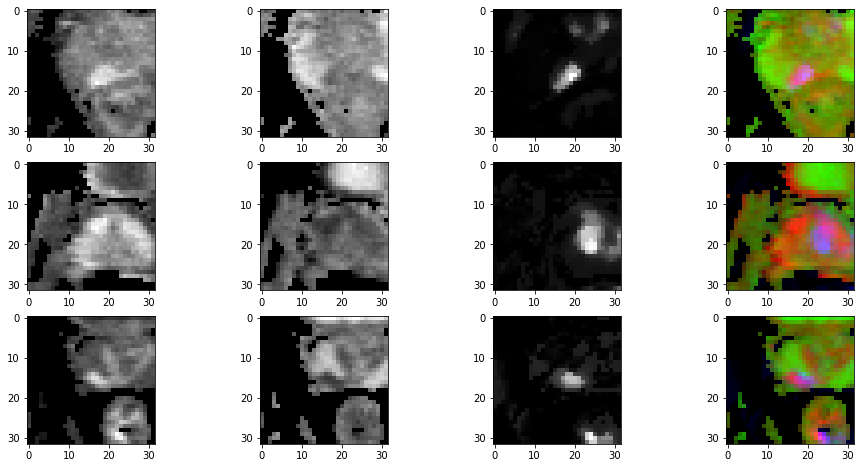

In [42]:
column = len(query) + 1 if len(query) < 5 else len(query)
row = [0, 1, 2]
fig, ax = plt.subplots(len(row), column, figsize=(4 * column, 8))
for r in row:
    if len(query) < 5: 
        for c in range(len(query)):
            ax[r, c].imshow(images[r, c], cmap='gray')
        ax[r, -1].imshow(np.moveaxis(images[r], 0, -1))
    else:
        for c in range(column):
            ax[r, c].imshow(images[r, c], cmap='gray')
fig.show()


## Save

In [43]:
images.shape

(321, 3, 32, 32)

In [45]:
dirname = 'dak_images'
_ = [os.makedirs(dirname+split+label) for split in ['/train', '/valid', '/valid_bal'] for label in ['/0', '/1']]
for i in range(X_train.shape[0]):
    image = X_train[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
    im.save(dirname + '/train/{}/{}.png'.format(1 if y_train[i] else 0, i))
for i in range(X_valid.shape[0]):
    image = X_valid[i]
    rescaled = (255.0 / image.max() * (image - image.min())).astype(np.uint8)
    im = Image.fromarray(np.moveaxis(rescaled, 0, -1))
    im.save(dirname + '/valid/{}/{}.png'.format(1 if y_valid[i] else 0, i))
    if i <= X_valid.shape[0]//2:
        im.save(dirname + '/valid_bal/{}/{}.png'.format(1 if y_valid[i] else 0, i))

In [61]:
transform = transforms.Compose([
    transforms.RandomAffine(degrees=5, translate=(1/32, 1/32), shear=5),
    transforms.ToTensor()
])

datasets = {}
datasets['train'] = torchvision.datasets.ImageFolder('dak_images/train', transform=transform)
datasets['valid'] = torchvision.datasets.ImageFolder('dak_images/valid')

## Transform

In [191]:
import torchvision
from torchvision import transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=20, translate=(0.1, 0.1), shear=[-5, 5, -5, 5]),
])

def npy_loader(path: str) -> np.ndarray:
    return np.load(path)

datasets = {}
datasets['train'] = torchvision.datasets.DatasetFolder('tbak_npy/train', extensions='npy', loader=npy_loader, transform=transform)
dl = torch.utils.data.DataLoader(datasets['train'], batch_size=16, num_workers=16, drop_last=True, shuffle=True)
a = next(iter(dl))
a[0].shape

torch.Size([16, 4, 64, 64])

In [195]:
a[0][0].shape

torch.Size([4, 64, 64])

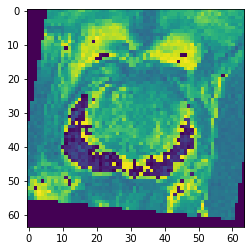

In [204]:
i = np.asarray(a[0][0,0])
# i = np.moveaxis(np.asarray(a[0][0]), 0, -1)
# i = np.moveaxis(np.asarray(a[0][0,:3]), 0, -1)
plt.imshow(i)